In [16]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [17]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
df= pd.read_csv("/content/drive/MyDrive/Research Papers/XAI/Data/Dataset_Without_Lagged_Variables.csv")

In [19]:
df

,STATE,YEAR,real GDP(in billion U.S. dollars),ENROLL,TOTAL_EXPENDITURE,PER_CAPITA_EXPENDITURE,INSTRUCTION_EXPENDITURE_RATIO,SUPPORT_SERVICES_EXPENDITURE_RATIO,CAPITAL_OUTLAY_EXPENDITURE_RATIO
0,Alabama,2000,157.22,730184,5003267,6.852063,0.510009,0.263638,0.132694
1,Alabama,2001,156.85,728532,5086045,6.981224,0.522291,0.270203,0.106229
2,Alabama,2002,160.42,726367,5147821,7.087080,0.528522,0.274795,0.096380
3,Alabama,2003,165.13,727900,5298932,7.279753,0.531638,0.287126,0.081579
4,Alabama,2004,176.63,730418,5450269,7.461849,0.527606,0.290014,0.082495
...,...,...,...,...,...,...,...,...,...
845,Wyoming,2012,38.86,89994,1670728,18.564882,0.506247,0.323518,0.127636
846,Wyoming,2013,38.85,91533,1675477,18.304622,0.505451,0.326129,0.127677
847,Wyoming,2014,39.56,92732,1775999,19.151954,0.487575,0.312929,0.162149
848,Wyoming,2015,40.42,93867,1942406,20.693172,0.461237,0.291128,0.210782


In [21]:
# Define features (X) and target (y)
X = df[["TOTAL_EXPENDITURE", "PER_CAPITA_EXPENDITURE",
          "INSTRUCTION_EXPENDITURE_RATIO", "SUPPORT_SERVICES_EXPENDITURE_RATIO",
          "CAPITAL_OUTLAY_EXPENDITURE_RATIO"]]
y = df["real GDP(in billion U.S. dollars)"]

In [22]:
# Group by STATE and split within each state by YEAR
train_data = pd.DataFrame()
test_data = pd.DataFrame()

In [23]:
# Split the dataset by year within each state (state-wise temporal split)
cutoff_year = 2014
for state in df["STATE"].unique():
    state_data = df[df["STATE"] == state]
    train_data = pd.concat([train_data, state_data[state_data["YEAR"] < cutoff_year]])
    test_data = pd.concat([test_data, state_data[state_data["YEAR"] >= cutoff_year]])

In [24]:
# Define features (X) and target (y) for training and testing
X_train = train_data[["TOTAL_EXPENDITURE", "PER_CAPITA_EXPENDITURE",
                      "INSTRUCTION_EXPENDITURE_RATIO", "SUPPORT_SERVICES_EXPENDITURE_RATIO",
                      "CAPITAL_OUTLAY_EXPENDITURE_RATIO"]]
y_train = train_data["real GDP(in billion U.S. dollars)"]

X_test = test_data[["TOTAL_EXPENDITURE", "PER_CAPITA_EXPENDITURE",
                    "INSTRUCTION_EXPENDITURE_RATIO", "SUPPORT_SERVICES_EXPENDITURE_RATIO",
                    "CAPITAL_OUTLAY_EXPENDITURE_RATIO"]]
y_test = test_data["real GDP(in billion U.S. dollars)"]

In [26]:
# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
# Reshape the data for LSTM (3D format: samples, time steps, features)
X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [28]:
# Build the improved LSTM model
model = Sequential([
    Bidirectional(LSTM(128, activation='tanh', return_sequences=True), input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dropout(0.3),
    LSTM(64, activation='tanh', return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),  # Fully connected layer for additional feature extraction
    Dense(1)  # Output layer for regression
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [29]:
# Compile the model with a custom learning rate
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

In [30]:

# Early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

In [31]:
# Train the LSTM model
history = model.fit(
    X_train_reshaped, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,  # Increased batch size
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - loss: 237668.5156 - mae: 311.3661 - val_loss: 195155.9219 - val_mae: 278.1443 - learning_rate: 0.0010
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 218256.3281 - mae: 295.1054 - val_loss: 195045.3281 - val_mae: 278.0497 - learning_rate: 0.0010
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 201981.7344 - mae: 294.2136 - val_loss: 194820.9531 - val_mae: 277.8804 - learning_rate: 0.0010
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 224156.2969 - mae: 306.0340 - val_loss: 194369.9062 - val_mae: 277.5476 - learning_rate: 0.0010
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 234310.9844 - mae: 304.6678 - val_loss: 193532.8750 - val_mae: 276.9081 - learning_rate: 0.0010
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 209219.2500 - mae: 286.8250 - val_loss: 192193.2500 - val_mae: 275.7797 - learning_rate: 0.0010
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 194612.6250 - mae

In [32]:
# Evaluate the LSTM model
y_pred = model.predict(X_test_reshaped).flatten()
metrics = {
    "R2 Score": r2_score(y_test, y_pred),
    "MAE": mean_absolute_error(y_test, y_pred),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred))
}

print("Improved LSTM Model Metrics:")
print(metrics)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step
Improved LSTM Model Metrics:
{'R2 Score': 0.698339847910248, 'MAE': 75.9297762084961, 'RMSE': 232.88427234158246}


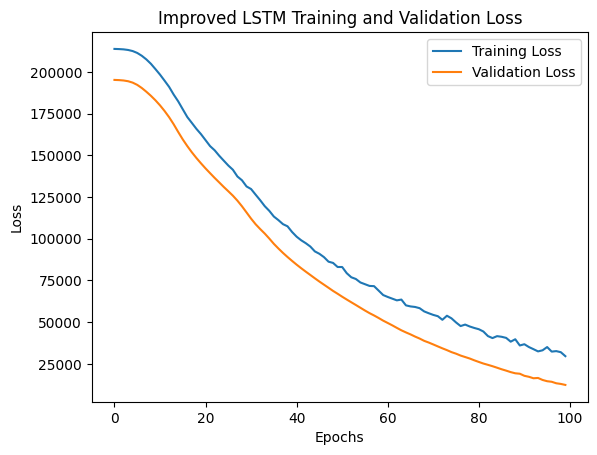

In [33]:

# Plot training history
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Improved LSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## SHAP

In [38]:
!pip install shap

In [63]:
# Import SHAP and visualization libraries
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [64]:
# Ensure the LSTM model is trained
# If not already done, train the improved LSTM model
model.fit(X_train_reshaped, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=1)


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 2804.1299 - mae: 29.2465 - val_loss: 14599.5518 - val_mae: 58.5687
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2311.8179 - mae: 28.7874 - val_loss: 15305.3232 - val_mae: 58.8741
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1319.1757 - mae: 25.1370 - val_loss: 13167.2803 - val_mae: 56.0716
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2518.2188 - mae: 28.5472 - val_loss: 13790.2256 - val_mae: 56.6297
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2166.8535 - mae: 27.9580 - val_loss: 14061.2441 - val_mae: 57.9030
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2916.5500 - mae: 28.5198 - val_loss: 15466.4287 - val_mae: 59.8892
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2585.4363 - mae: 29.5714 - val_loss: 13385.3945 - val_mae: 56.5621
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1720.2266 - mae: 26.5749 - val_loss: 14760.9697 - val_mae: 58.0480


In [65]:
# Convert reshaped X_test into a DataFrame for SHAP with feature names
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=[
    "TOTAL_EXPENDITURE", "PER_CAPITA_EXPENDITURE",
    "INSTRUCTION_EXPENDITURE_RATIO", "SUPPORT_SERVICES_EXPENDITURE_RATIO",
    "CAPITAL_OUTLAY_EXPENDITURE_RATIO"
])

In [66]:
# Custom wrapper function to make the LSTM model compatible with SHAP
def model_predict(input_data):
    # Convert 2D input to 3D for LSTM
    reshaped_input = np.reshape(input_data, (input_data.shape[0], 1, input_data.shape[1]))
    return model.predict(reshaped_input)


In [67]:
# Initialize the SHAP Explainer using the custom prediction wrapper
explainer = shap.Explainer(model_predict, X_test_scaled_df)

In [68]:
# Compute SHAP values for the test set
shap_values = explainer(X_test_scaled_df)

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


ExactExplainer explainer:   8%|▊         | 12/150 [00:00<?, ?it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


ExactExplainer explainer:   9%|▉         | 14/150 [00:11<00:58,  2.33it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


ExactExplainer explainer:  10%|█         | 15/150 [00:12<01:27,  1.55it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


ExactExplainer explainer:  11%|█         | 16/150 [00:13<01:22,  1.63it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


ExactExplainer explainer:  11%|█▏        | 17/150 [00:13<01:22,  1.62it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  12%|█▏        | 18/150 [00:14<01:17,  1.71it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


ExactExplainer explainer:  13%|█▎        | 19/150 [00:15<01:26,  1.51it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ExactExplainer explainer:  13%|█▎        | 20/150 [00:15<01:22,  1.58it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  14%|█▍        | 21/150 [00:16<01:17,  1.67it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


ExactExplainer explainer:  15%|█▍        | 22/150 [00:16<01:14,  1.72it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  15%|█▌        | 23/150 [00:17<01:11,  1.77it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


ExactExplainer explainer:  16%|█▌        | 24/150 [00:18<01:24,  1.49it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  17%|█▋        | 25/150 [00:18<01:17,  1.61it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  17%|█▋        | 26/150 [00:19<01:23,  1.48it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  18%|█▊        | 27/150 [00:20<01:17,  1.58it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


ExactExplainer explainer:  19%|█▊        | 28/150 [00:20<01:16,  1.59it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


ExactExplainer explainer:  19%|█▉        | 29/150 [00:21<01:12,  1.67it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  20%|██        | 30/150 [00:21<01:08,  1.74it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


ExactExplainer explainer:  21%|██        | 31/150 [00:22<01:20,  1.48it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ExactExplainer explainer:  21%|██▏       | 32/150 [00:23<01:25,  1.39it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


ExactExplainer explainer:  22%|██▏       | 33/150 [00:24<01:31,  1.28it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ExactExplainer explainer:  23%|██▎       | 34/150 [00:25<01:36,  1.20it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ExactExplainer explainer:  23%|██▎       | 35/150 [00:26<01:39,  1.15it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  24%|██▍       | 36/150 [00:26<01:29,  1.27it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


ExactExplainer explainer:  25%|██▍       | 37/150 [00:27<01:19,  1.42it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  25%|██▌       | 38/150 [00:28<01:22,  1.36it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  26%|██▌       | 39/150 [00:28<01:16,  1.46it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  27%|██▋       | 40/150 [00:29<01:19,  1.38it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  27%|██▋       | 41/150 [00:30<01:11,  1.52it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  28%|██▊       | 42/150 [00:30<01:08,  1.57it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  29%|██▊       | 43/150 [00:31<01:06,  1.61it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  29%|██▉       | 44/150 [00:32<01:14,  1.43it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ExactExplainer explainer:  30%|███       | 45/150 [00:33<01:20,  1.30it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ExactExplainer explainer:  31%|███       | 46/150 [00:33<01:24,  1.23it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ExactExplainer explainer:  31%|███▏      | 47/150 [00:34<01:26,  1.19it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


ExactExplainer explainer:  32%|███▏      | 48/150 [00:35<01:30,  1.13it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


ExactExplainer explainer:  33%|███▎      | 49/150 [00:36<01:37,  1.04it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


ExactExplainer explainer:  33%|███▎      | 50/150 [00:38<01:57,  1.18s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


ExactExplainer explainer:  34%|███▍      | 51/150 [00:39<01:49,  1.11s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


ExactExplainer explainer:  35%|███▍      | 52/150 [00:40<01:44,  1.06s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ExactExplainer explainer:  35%|███▌      | 53/150 [00:41<01:41,  1.04s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ExactExplainer explainer:  36%|███▌      | 54/150 [00:42<01:38,  1.02s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ExactExplainer explainer:  37%|███▋      | 55/150 [00:43<01:35,  1.00s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ExactExplainer explainer:  37%|███▋      | 56/150 [00:44<01:31,  1.02it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  38%|███▊      | 57/150 [00:45<01:29,  1.04it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


ExactExplainer explainer:  39%|███▊      | 58/150 [00:46<01:26,  1.06it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  39%|███▉      | 59/150 [00:46<01:15,  1.21it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


ExactExplainer explainer:  40%|████      | 60/150 [00:47<01:16,  1.18it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  41%|████      | 61/150 [00:48<01:06,  1.34it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ExactExplainer explainer:  41%|████▏     | 62/150 [00:49<01:10,  1.25it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ExactExplainer explainer:  42%|████▏     | 63/150 [00:50<01:13,  1.18it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


ExactExplainer explainer:  43%|████▎     | 64/150 [00:51<01:14,  1.16it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


ExactExplainer explainer:  43%|████▎     | 65/150 [00:52<01:36,  1.13s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


ExactExplainer explainer:  44%|████▍     | 66/150 [00:54<01:43,  1.23s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


ExactExplainer explainer:  45%|████▍     | 67/150 [00:55<01:55,  1.39s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


ExactExplainer explainer:  45%|████▌     | 68/150 [00:57<01:59,  1.46s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ExactExplainer explainer:  46%|████▌     | 69/150 [00:58<01:44,  1.29s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ExactExplainer explainer:  47%|████▋     | 70/150 [00:59<01:35,  1.19s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ExactExplainer explainer:  47%|████▋     | 71/150 [01:00<01:27,  1.11s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


ExactExplainer explainer:  48%|████▊     | 72/150 [01:01<01:22,  1.06s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


ExactExplainer explainer:  49%|████▊     | 73/150 [01:02<01:19,  1.03s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ExactExplainer explainer:  49%|████▉     | 74/150 [01:03<01:15,  1.01it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  50%|█████     | 75/150 [01:04<01:10,  1.06it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  51%|█████     | 76/150 [01:04<01:00,  1.23it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  51%|█████▏    | 77/150 [01:05<00:52,  1.38it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


ExactExplainer explainer:  52%|█████▏    | 78/150 [01:06<00:57,  1.25it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  53%|█████▎    | 79/150 [01:06<00:57,  1.24it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ExactExplainer explainer:  53%|█████▎    | 80/150 [01:07<00:58,  1.19it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ExactExplainer explainer:  54%|█████▍    | 81/150 [01:08<01:01,  1.13it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


ExactExplainer explainer:  55%|█████▍    | 82/150 [01:09<01:01,  1.11it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


ExactExplainer explainer:  55%|█████▌    | 83/150 [01:10<01:01,  1.09it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ExactExplainer explainer:  56%|█████▌    | 84/150 [01:11<00:58,  1.13it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  57%|█████▋    | 85/150 [01:12<00:56,  1.16it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  57%|█████▋    | 86/150 [01:13<00:54,  1.16it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ExactExplainer explainer:  58%|█████▊    | 87/150 [01:13<00:49,  1.28it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  59%|█████▊    | 88/150 [01:14<00:43,  1.42it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  59%|█████▉    | 89/150 [01:15<00:45,  1.35it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ExactExplainer explainer:  60%|██████    | 90/150 [01:15<00:40,  1.49it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  61%|██████    | 91/150 [01:16<00:42,  1.39it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  61%|██████▏   | 92/150 [01:17<00:43,  1.34it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  62%|██████▏   | 93/150 [01:18<00:43,  1.30it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  63%|██████▎   | 94/150 [01:18<00:43,  1.28it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ExactExplainer explainer:  63%|██████▎   | 95/150 [01:19<00:45,  1.22it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ExactExplainer explainer:  64%|██████▍   | 96/150 [01:20<00:45,  1.18it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


ExactExplainer explainer:  65%|██████▍   | 97/150 [01:21<00:41,  1.29it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


ExactExplainer explainer:  65%|██████▌   | 98/150 [01:22<00:43,  1.21it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ExactExplainer explainer:  66%|██████▌   | 99/150 [01:23<00:43,  1.17it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ExactExplainer explainer:  67%|██████▋   | 100/150 [01:24<00:44,  1.13it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


ExactExplainer explainer:  67%|██████▋   | 101/150 [01:24<00:43,  1.13it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


ExactExplainer explainer:  68%|██████▊   | 102/150 [01:25<00:43,  1.11it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  69%|██████▊   | 103/150 [01:26<00:38,  1.23it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  69%|██████▉   | 104/150 [01:27<00:33,  1.36it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ExactExplainer explainer:  70%|███████   | 105/150 [01:27<00:31,  1.44it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  71%|███████   | 106/150 [01:28<00:32,  1.37it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


ExactExplainer explainer:  71%|███████▏  | 107/150 [01:29<00:33,  1.28it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  72%|███████▏  | 108/150 [01:30<00:33,  1.26it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  73%|███████▎  | 109/150 [01:31<00:32,  1.25it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


ExactExplainer explainer:  73%|███████▎  | 110/150 [01:31<00:29,  1.36it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


ExactExplainer explainer:  74%|███████▍  | 111/150 [01:32<00:30,  1.27it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


ExactExplainer explainer:  75%|███████▍  | 112/150 [01:33<00:27,  1.36it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ExactExplainer explainer:  75%|███████▌  | 113/150 [01:33<00:24,  1.48it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  76%|███████▌  | 114/150 [01:34<00:22,  1.57it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


ExactExplainer explainer:  77%|███████▋  | 115/150 [01:35<00:24,  1.44it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


ExactExplainer explainer:  77%|███████▋  | 116/150 [01:35<00:22,  1.50it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ExactExplainer explainer:  78%|███████▊  | 117/150 [01:36<00:24,  1.35it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


ExactExplainer explainer:  79%|███████▊  | 118/150 [01:37<00:25,  1.26it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ExactExplainer explainer:  79%|███████▉  | 119/150 [01:38<00:26,  1.18it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


ExactExplainer explainer:  80%|████████  | 120/150 [01:39<00:26,  1.14it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


ExactExplainer explainer:  81%|████████  | 121/150 [01:40<00:26,  1.10it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


ExactExplainer explainer:  81%|████████▏ | 122/150 [01:41<00:25,  1.09it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


ExactExplainer explainer:  82%|████████▏ | 123/150 [01:41<00:22,  1.22it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  83%|████████▎ | 124/150 [01:42<00:21,  1.19it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  83%|████████▎ | 125/150 [01:43<00:18,  1.34it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  84%|████████▍ | 126/150 [01:43<00:16,  1.44it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


ExactExplainer explainer:  85%|████████▍ | 127/150 [01:44<00:15,  1.50it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  85%|████████▌ | 128/150 [01:45<00:15,  1.40it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  86%|████████▌ | 129/150 [01:45<00:14,  1.49it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  87%|████████▋ | 130/150 [01:46<00:13,  1.53it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  87%|████████▋ | 131/150 [01:47<00:12,  1.54it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  88%|████████▊ | 132/150 [01:47<00:11,  1.62it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  89%|████████▊ | 133/150 [01:48<00:11,  1.43it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


ExactExplainer explainer:  89%|████████▉ | 134/150 [01:49<00:10,  1.53it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ExactExplainer explainer:  90%|█████████ | 135/150 [01:49<00:09,  1.55it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


ExactExplainer explainer:  91%|█████████ | 136/150 [01:50<00:08,  1.58it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


ExactExplainer explainer:  91%|█████████▏| 137/150 [01:51<00:09,  1.38it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


ExactExplainer explainer:  92%|█████████▏| 138/150 [01:52<00:09,  1.30it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


ExactExplainer explainer:  93%|█████████▎| 139/150 [01:53<00:08,  1.22it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


ExactExplainer explainer:  93%|█████████▎| 140/150 [01:54<00:08,  1.17it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


ExactExplainer explainer:  94%|█████████▍| 141/150 [01:55<00:08,  1.11it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  95%|█████████▍| 142/150 [01:55<00:07,  1.10it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


ExactExplainer explainer:  95%|█████████▌| 143/150 [01:56<00:05,  1.22it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  96%|█████████▌| 144/150 [01:57<00:04,  1.31it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


ExactExplainer explainer:  97%|█████████▋| 145/150 [01:58<00:03,  1.28it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ExactExplainer explainer:  97%|█████████▋| 146/150 [01:58<00:02,  1.36it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  98%|█████████▊| 147/150 [01:59<00:02,  1.31it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


ExactExplainer explainer:  99%|█████████▊| 148/150 [02:00<00:01,  1.39it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ExactExplainer explainer:  99%|█████████▉| 149/150 [02:00<00:00,  1.48it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer: 100%|██████████| 150/150 [02:01<00:00,  1.53it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer: 151it [02:01,  1.14it/s]


In [72]:
# --- 1. Force Plot (Local Explanation for One Prediction) ---
shap.initjs()  # Initialize JavaScript visualization
single_prediction = 0  # Index of the test sample to explain
shap.force_plot(
    shap_values.base_values[single_prediction],  # Use base_values instead of expected_value
    shap_values.values[single_prediction],  # Access the SHAP values directly
    X_test_scaled_df.iloc[single_prediction]
)

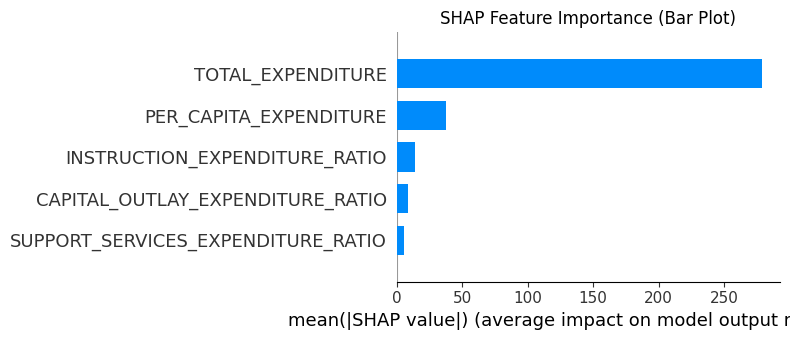

In [70]:
# --- 2. Feature Importance (Global Explanation) ---
# Bar plot of mean absolute SHAP values
plt.title("SHAP Feature Importance (Bar Plot)")
shap.summary_plot(shap_values, X_test_scaled_df, plot_type="bar")

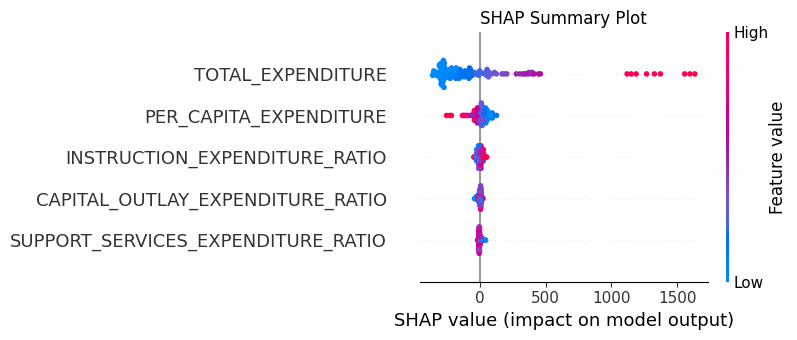

In [71]:
# --- 3. Summary Plot (Global Explanation of Feature Impacts) ---
# Distribution of SHAP values for each feature
plt.title("SHAP Summary Plot")
shap.summary_plot(shap_values, X_test_scaled_df)